# Astro 330 "Computational Astrophysics"

## Homework 2 

### Student: Dimitrios Tanoglidis

### Problem 1 (20 points) Implementing Romberg integration.

Implement a routine performing Romberg integration of input function $f(x)$ and integration interval $[a,b]$ to a specified fractional error tolerance. Implement the integration routine in such a way that one can pass a list of parameter values of arbitrary size to $f(x)$.
Namely, implement the function with the following inputs and outputs:

def romberg(func, a, b, rtol, *args):
    """
    Parameters:
    --------------------------------
    func - python function object
           function to integrate
    a, b - floats
           integration interval
    rtol - float 
           fractional tolerance of the integral estimate
    args - list
           a list of parameters to pass to func
           parameters must be in order and number expected by func

    Returns:
    ---------------------------------
    I    - float
           estimate of the integral for input f, [a,b] and rtol
    err  - float 
           estimated fractional error of the estimated integral
    """



##### Hints:
Estimate the integral using $R_{m,m}$ using recursion formula derived in S 2.2.2 of the notes, where $m$ is sufficiently high to achieve the required accuracy. For $R_{0,0}$ you can use the trapezoidal integration scheme with just two edge points a and b or h=b-a. Example of a similar implementation of recursive function calls is given in my Dkm routine for computing first derivative using Richardson extrapolation in ex03 notebook. Current accuracy of the integral estimate can be approximated conservatively by $\vert R_{m,m}-R_{m,m-1}\vert$.

Example of how one can pass a flexible list of parameters using args handle is in the hybrid_root_find2 function in my solutions to homework 1. You can also check this brief tutorial.

##### Required tests and follow up questions:
test your routine by computing $$\int_0^1 e^x dx$$ for different $\delta$ values and comparing results with the true value of the integral.


### Solution

In [74]:
import numpy as np


def romberg(func, a, b, rtol, *args): 
    
    """
    Parameters:
    --------------------------------
    func - python function object
           function to integrate
    a, b - floats
           integration interval
    rtol - float 
           fractional tolerance of the integral estimate
    args - list
       a list of parameters to pass to func
       parameters must be in order and number expected by func

    Returns:
    ---------------------------------
    I    - float
           estimate of the integral for input f, [a,b] and rtol
    err  - float 
           estimated fractional error of the estimated integral
    """
    
    h = b - a
    
    # Define a function that calculates the order k,m Roemberg scheme using a recursive relation
    
    def R(k, m):
        if (m == 0):
            Np = int(2.0**k)
            hd = h/2.**k
            xd = a + np.arange(Np)*hd
            dummy = (0.5*(func(a, *args) + func(b, *args)) + np.sum(func(xd[1:], *args))) * hd
        else:
            fact = 4.**m
            dummy = (fact*R(k, m - 1) - R(k -1, m - 1))/(fact - 1.0)
        return dummy
    
    #Initial estimations of the integral to start with
    
    mu = 1

    best_est = R(mu,mu)               #Best estimation of the integral 
    sec_best_est = R(mu, mu -1)           #Second-best estimation of the integral
    
    
    #Fractional error 
    
    frac_err = np.abs(best_est - sec_best_est)/best_est
    
    #While frac_err > rtol repeat the proces
    
   
    while (frac_err >  rtol):
        mu = mu + 1
        best_est = R(mu,mu)
        sec_best_est = R(mu,mu-1)
        
        frac_err = np.abs(best_est - sec_best_est)/best_est
        
        
    
    #print(mu)
    return best_est, frac_err, mu



Now calculate the integral:

\begin{equation}
I = \int_0^1 e^x = e - 1 
\end{equation}

In [75]:
#Analytic solution

an_sol = np.exp(1)-1.0

#Print analytic solution 

print('Analytic solution of the integral is : %.18f'%an_sol)

Analytic solution of the integral is : 1.718281828459045091


In [76]:
# Numerical solution for various relative tolerances 

tol_1 = 1.0e-5

tol_2 = 1.0e-10

tol_3 = 1.0e-18

Int_1, err_1, mu_1 = romberg(np.exp, 0, 1, tol_1)

print('Romberg solution with tolerance %.20f is %.18f and error %.20f'%(tol_1, Int_1, err_1))
print('Achieved in step no:%.1f'%mu_1)

Int_2, err_2, mu_2 = romberg(np.exp, 0, 1, tol_2)

print('Romberg solution with tolerance %.20f is %.18f and error %.20f'%(tol_2, Int_2, err_2))
print('Achieved in step no :%.1f'%mu_2)

Int_3, err_3, mu_3 = romberg(np.exp, 0, 1, tol_3)

print('Romberg solution with tolerance %.20f is %.18f and error %.20f'%(tol_3, Int_3, err_3))
print('Achieved in step no %.1f:'%mu_3)

Romberg solution with tolerance 0.00001000000000000000 is 1.718281828794530508 and error 0.00000000781240279482
Achieved in step no:3.0
Romberg solution with tolerance 0.00000000010000000000 is 1.718281828459078175 and error 0.00000000000076268470
Achieved in step no :4.0
Romberg solution with tolerance 0.00000000000000000100 is 1.718281828459044869 and error 0.00000000000000000000
Achieved in step no 5.0:


## Problem 2

### 2a (10 points). Applying your Romberg integration.

Use the routine implemented in 1 to compute rms fluctuations of matter density in a universe, $\sigma(R)$, using formula given in the "Background" above for a range of $R$ values $R\in [10^{-2},10^3]$ (where $R$ is in $h^{-1}$ Mpc).

Hints: Think about the integrand and the integration variable to use to optimize the integration.

##### Required tests and follow up questions: 

Test your results by comparing against results of similar integration using Romberg integration routine from scipy. for the same range of $R$ and fractional error tolerance. Namely, print out the values of the integral and fractional difference between the two calculations.

Plot $\sigma$ as a function of $R$ using results of your calculation and calculation using scipy Romberg routine.
Time your and scipy's routines using time routine. How different is performance on this integral between your routine in the scipy routine?


### Solution

The formula for the variance $\sigma(R)^2$ is (writing explicitly the top-hat window function inside the integral):

\begin{equation}
\sigma^2(R) = \frac{1}{2\pi^2} \int_0^\infty k^2 P(k) \left[ \frac{3}{(kR)^3}\left(\sin kR - kR \cos kR \right) \right]^2 dk \qquad (1)
\end{equation}

Defining the new variable $u = kR \Rightarrow k = u/R$, eq. (1) becomes:

\begin{equation}
\sigma^2(R) =  \frac{1}{R^3} \frac{9}{2\pi^2} \int_0^{\infty} \frac{P(u/R)}{u^4}\left(\sin u - u \cos u\right)^2 du 
\end{equation}

To get a sense of what is the range of values of $u$ that most contribute to the integral, let's plot the integrant $\frac{P(u/R)}{u^4}\left(\sin u - u \cos u\right)^2$ for a few characteristic values of $R$, say  $R = 10^{-2}, 10, 10^3$ ($h^{-1}$ Mpc).


##### Plotting the integrand for three values of R

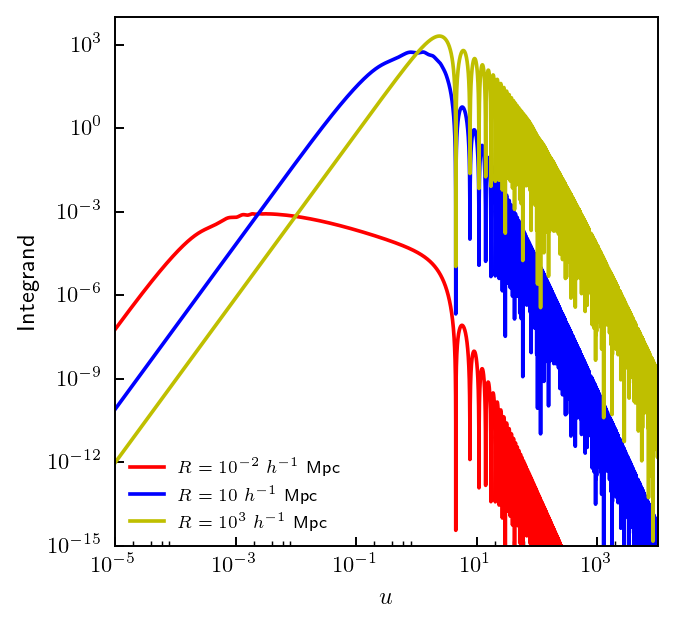

In [77]:
import numpy as np
from colossus.cosmology import cosmology

import matplotlib.pyplot as plt
%matplotlib inline

from code.plot_utils import plot_pretty
plot_pretty()

# define a vector of cosmological parameters:    
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
z = 0.0

# set my_cosmo to be the current cosmology; 
# setCosmology returns a colossus cosmology object with useful functions
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)
# switch off internal colossus spline interpolation
cosmo.interpolation = False

#============================================================
#============================================================

# Define the three values of R

R_1 = 1.0e-2
R_2 = 10.0
R_3 = 1.0e3

# Define range in u

u_min = 1.0e-5
u_max = 1.0e4

u_lin = np.linspace(np.log10(u_min), np.log10(u_max), 10000) #linear spacing 
u = 10.0**u_lin 

#Now calculate the integrand for the three values of R

integrand_1  = (cosmo.matterPowerSpectrum(u/R_1, 'eh98'))*((np.sin(u) - u*np.cos(u))**2.0)/(u**4.0)
integrand_2  = (cosmo.matterPowerSpectrum(u/R_2, 'eh98'))*((np.sin(u) - u*np.cos(u))**2.0)/(u**4.0)
integrand_3  = (cosmo.matterPowerSpectrum(u/R_3, 'eh98'))*((np.sin(u) - u*np.cos(u))**2.0)/(u**4.0)

#Plot them

plt.figure(figsize=(4,4))

plt.plot(u, integrand_1, c='r' , label=r'$R=10^{-2} \,\,h^{-1}$ Mpc')
plt.plot(u, integrand_2, c ='b', label=r'$R=10 \,\,h^{-1}$ Mpc')
plt.plot(u, integrand_3, c='y', label=r'$R=10^{3} \,\,h^{-1}$ Mpc')




plt.xscale('log');plt.yscale('log')
plt.xlim(1.0e-5,1.0e4)
plt.ylim(1.0e-15,1.0e4)

plt.xlabel('$u$', fontsize = 10) 
plt.ylabel('Integrand', fontsize = 10)

plt.legend(frameon=False, loc='lower left', fontsize=7)

plt.show()



We can use the above plot to guide us in the process of calculating the integral.

First of all, we see that the main contribution to the integral comes from the range (in u) of $\sim 10^{-2} - 10^{2}$. Thus, taking the limits of the integral to be $u = [10^{-5}, 10^3]$ will be sufficient for our calculation. 

A second thing to note here is the oscillatory behaviour starts at a value of $u \sim {\cal{O}}(1).$ Thus is probably wise to split the integral into two parts, one that is easy to achieve the required tolerance and one that will take more time to achive that.


Also, we would like to integrate in log space. For that reason we define the variable $x = \log u \Rightarrow u = 10^x$. Also $dx = d \log u = du /u$. For the limits we set $-5, 4$ (logarithms of $u = 10^{-5}$ and $u= 10^{4}$, our previous limits).

So, the final formula for $\sigma^2(R)$ we are going to use is:

\begin{equation}
\sigma^2(R) = \frac{1}{R^3} \frac{9}{2\pi^2} \int_{-5}^{4} \frac{P(10^x/R)}{10^{3x}} \left(\sin 10^x - 10^x \cos 10^x \right)^2 dx = 
\end{equation}

\begin{equation}
= \frac{1}{R^3} \frac{9}{2\pi^2} \left\lbrace \int_{-5}^{1} \frac{P(10^x/R)}{10^{3x}} \left(\sin 10^x - 10^x \cos 10^x \right)^2 dx  + \int_{1}^{4} \frac{P(10^x/R)}{10^{3x}} \left(\sin 10^x - 10^x \cos 10^x \right)^2 dx \right\rbrace \qquad (2)
\end{equation}


We will calculate this using our formula for Roemberg integration and the spipy formula for Roemberg integration and compare them.

In [78]:
from scipy import integrate

from time import time 

# Define the function that gives the integrand for every x that we will use in the Roemberg integration

def integrand_rom(x, *args):
    rad = args[0]
    u_var = 10.0**x
    integrand = (cosmo.matterPowerSpectrum(u_var/rad, 'eh98'))*((np.sin(u_var) - u_var*np.cos(u_var))**2.0)/(u_var**3.0)
    return integrand


# Define a range in R (units h^{-1} Mpc) in which you want to calculate the sigma^2 of r _and thus sigma of R

R_lin = np.linspace(-2.0, 3.0, 100)
R = 10.0**R_lin

#==============================================================================================================
#==============================================================================================================

#The size of the the array of R's - we will use it to define arrays for our results
N = np.size(R)

#Create empty arrays where we are going to store the results of our calculations  - one using my code
# and one using scipy.romberg 

sigma_my_code = np.zeros(N)

sigma_scipy_rout = np.zeros(N)

#Now let's populate them, let's calculate sigma

for i in range (0,N):
    r_i = R[i]      # A new value for R each time
    prefact = (1.0/(r_i**3.0))*(4.5/(np.pi**2.0))
    
    # Calculation using my  Romberg function
    sigma_sq_mine = prefact*(romberg(integrand_rom, -5.0, 1.0, 1.0e-7, r_i)[0] + romberg(integrand_rom, 1.0, 4.0, 1.0e-7, r_i)[0])
    sigma_my_code[i] = np.sqrt(sigma_sq_mine) #sigma is the square root of the quantity we calculated above

    #Calculation using the scipy routine 
    
    sigma_sq_scipy = prefact*(integrate.romberg(integrand_rom, -5.0,1.0, args=(r_i,), rtol=1.0e-7)+integrate.romberg(integrand_rom, 1.0,4.0, args=(r_i,), rtol=1.0e-7))
    sigma_scipy_rout[i] = np.sqrt(sigma_sq_scipy) #sigma is the square root of the above quantity 

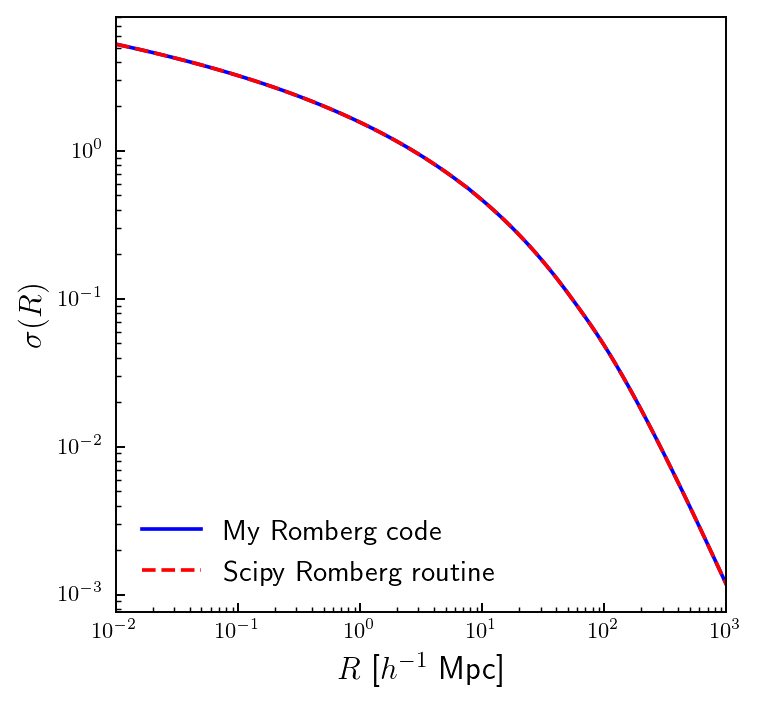

In [79]:
plt.figure(figsize=(4.5,4.5))

plt.plot(R, sigma_my_code, c='b', label=r'My Romberg code')
plt.plot(R, sigma_scipy_rout, ls ='--', c='r', label='Scipy Romberg routine')
plt.xscale('log');plt.yscale('log')

plt.xlim(1.0e-2, 1.0e3)

plt.xlabel('$R$ [$h^{-1}$ Mpc]', fontsize='13');plt.ylabel('$\sigma(R)$', fontsize='13')


plt.legend(frameon=False, loc='lower left', fontsize=12)
plt.show()



From the above we see that, at least for this level of relative tolerance ($ 1.0 \times 10^{-7}$) my code and the scipy Romberg agree very well.

To quantify this agreement, we will plot as a function of $R$ the quantity (fractional difference of the two calculations):

\begin{equation}
\delta = \frac{\left|\sigma(R)_{mine} - \sigma(R)_{scipy}\right|}{\sigma(R)_{mine}}
\end{equation}

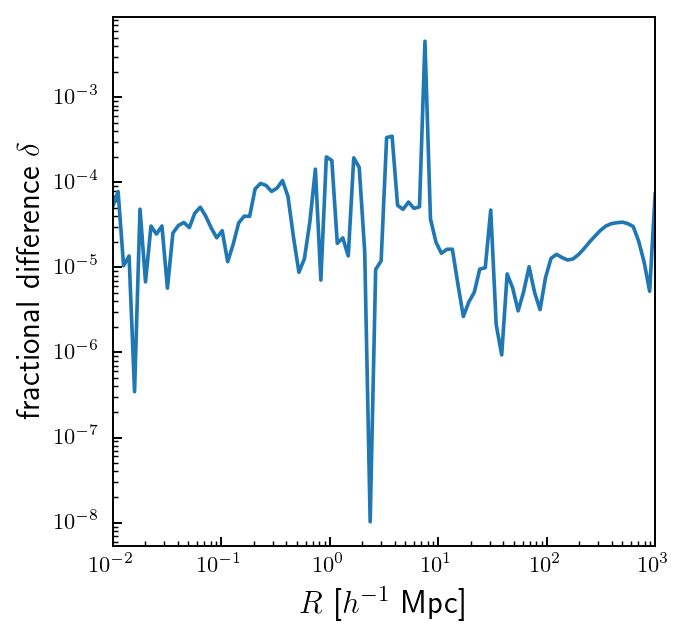

In [61]:
# Calculate fractional difference
frac_dif = np.abs(sigma_my_code - sigma_scipy_rout)/sigma_my_code

plt.figure(figsize=(4,4))

plt.plot(R, frac_dif)
plt.xscale('log');plt.yscale('log')

plt.xlabel('$R$ [$h^{-1}$ Mpc]', fontsize='13');plt.ylabel('fractional difference $\delta$', fontsize='13')
plt.xlim(1.0e-2, 1.0e3)

plt.show()


Thus the fractional difference of the two routines is of the order of $10^{-5}$.

### 2b (5 points) Using spline to integrate.

Approximate the integrand with spline using UnivariateSpline routine from the scipy package and compute the integral using integral method of the spline object. Repeat this for the integrand tabulated for evenly spaced $k$ values and for evenly spaced $\ln k$ values. Try using different number of tabulated points for spline approximation of the integrand.

Hints: make sure you use s=0 for smoothing parameter. See S 2.1.8 of my notes for the way integrals are estimated with splines. Note that for $\ln k$ spaced values integrand needs to change (due to change of integration variable).

If you don't get your Romberg integration routine to work properly, use the scipy Romberg routine to do the job.

##### Required tests and follow up questions: 
How many points you need to use to approximate the integrand with the spline in order to achieve accuracy of direct intergation for the two choices of tabulation $k$ values (evenly spaced in $k$ or $\ln k$). Discuss reasons for the difference.

Plot the fractional differences as a function of $R$ (for $R\in [10^{-2}, 10^3]$) between results of your routine and those of the scipy Romberg routine and the two estimates with spline integral method. Discuss what you can conclude from this comparison.

### Solution


First of all, I'm gonna keep working using the variable $u$ defined above in order to be able to make a fair comparison between the different methods.

Let's start using 1000 tabulated points. 

In [62]:
from scipy.interpolate import UnivariateSpline

# Create empty arrays that we will populate with the results of our calculations 

sigma_interp_evenu = np.zeros(N) #Will contain results for evenly spaced u values

sigma_interp_evenlogu = np.zeros(N) #Will contain results for evenly spaced logu values

for i in range(0,N):
    r_i = R[i]
    prefact = (1.0/(r_i**3.0))*(9.0/(np.pi**2.0))/2.0
    
    #===============================================================================================
    #===============================================================================================
    # First, for each R, calculation of the integral and sigma using 1000 tabulated points
    # of u evenly spaced 
    
    u_even = np.linspace(1.0e-5, 1.0e4, 1000)
    
    integrand_even_u = (cosmo.matterPowerSpectrum(u_even/r_i, 'eh98'))*((np.sin(u_even) - u_even*np.cos(u_even))**2.0)/(u_even**4.0)
    
    # Now interpolate to find the integrand for every u
    
    spl_integ_even_u = UnivariateSpline(u_even, integrand_even_u, s=0.0)
    
    #calculate the integral using the spline method 
    
    sigma_sq = prefact*(spl_integ_even_u.integral(1.0e-5, 1.0e4))
    
    sigma_interp_evenu[i] = np.sqrt(sigma_sq)
    
    #==============================================================================================
    #==============================================================================================
    # Now, for R, calculation of the integral and sigma using 1000 tabulated points
    # of even space in logu 
    
    u_even_log = np.linspace(-5.0,4.0,1000)
    
    x_var = 10.0**u_even_log 
    
    integrand_even_log = (cosmo.matterPowerSpectrum(x_var/r_i, 'eh98'))*((np.sin(x_var) - x_var*np.cos(x_var))**2.0)/(x_var**3.0)
    
    # Now interpolate
    
    spl_integ_even_log = UnivariateSpline(u_even_log, integrand_even_log, s=0.0)
    
    #calculate the integral using the spline method 
    
    sigma_sq_2 = prefact*(spl_integ_even_log.integral(-5.0,4.0))
    
    sigma_interp_evenlogu[i] = np.sqrt(sigma_sq_2)

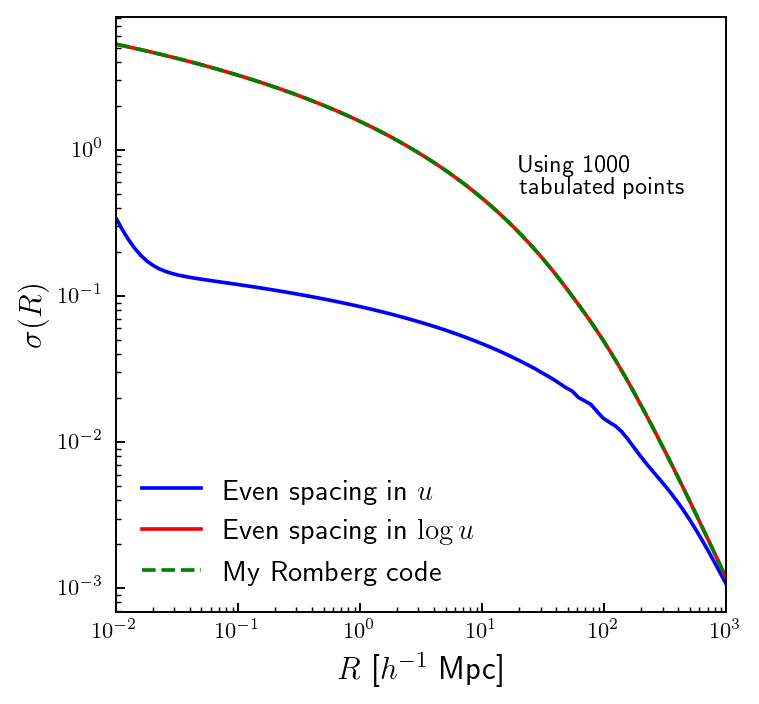

In [63]:
plt.figure(figsize=(4.5,4.5))

plt.plot(R, sigma_interp_evenu, c='b', label=r'Even spacing in $u$')
plt.plot(R, sigma_interp_evenlogu, c='r', label=r'Even spacing in $\log u$')
plt.plot(R, sigma_my_code , c='g', ls='--', label=r'My Romberg code')

plt.xscale('log');plt.yscale('log')

plt.xlim(1.0e-2, 1.0e3)

plt.xlabel('$R$ [$h^{-1}$ Mpc]', fontsize='13');plt.ylabel('$\sigma(R)$', fontsize='13')

plt.text(2.0e1,0.7, 'Using 1000', fontsize=10)
plt.text(2.0e1,0.5, 'tabulated points', fontsize=10)
plt.legend(frameon=False, loc='lower left', fontsize=12)
plt.show()

We see that for 1000 tabulated points, the result when spacing (evenly) in $u$ does not agree very well with the result from the Roemberg code, but when spacing (evenly) in $\log u$ the two results agree very well.

Let's try to quantify this.

Define the fractional difference here as:

\begin{equation}
\delta = \frac{\left|\sigma(R)_{method} - \sigma(R)_{mine}\right|}{\sigma(R)_{method}} 
\end{equation}

where, $method$ here refers to the results obtained using the spline integral method, for the two cases: even spacing in $u$ and even spacing in $\log u$. The denominator is $\sigma(R)_{method}$ because as we can see $\sigma(R)_{method} < \sigma(R)_{mine}$. Let's calculate and plot this fractional differences.

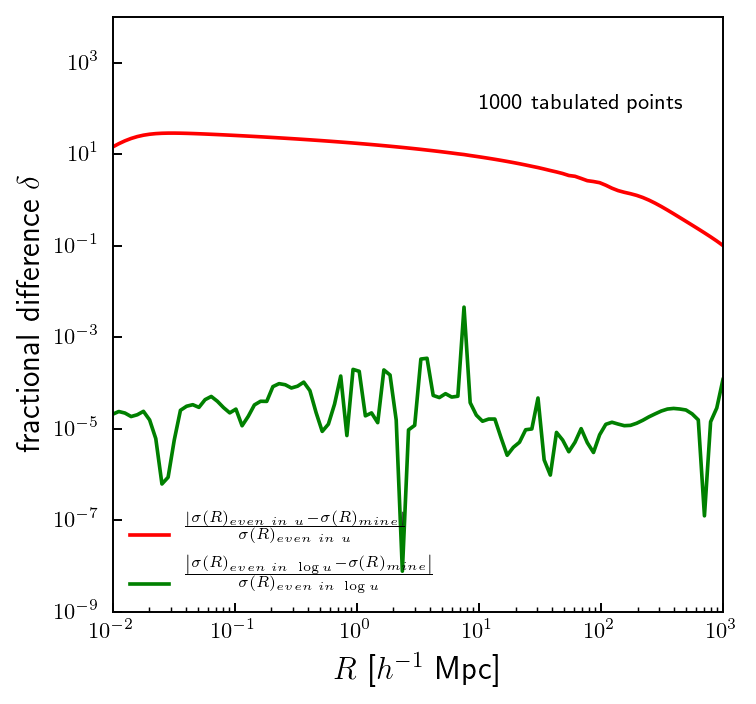

In [64]:
frac_dif_1 = np.abs(sigma_my_code - sigma_interp_evenu)/sigma_interp_evenu

frac_dif_2 = np.abs(sigma_my_code - sigma_interp_evenlogu)/sigma_interp_evenlogu


plt.figure(figsize=(4.5,4.5))

plt.plot(R, frac_dif_1, c='r', label=r'$\frac{\left|\sigma(R)_{even\,\,in\,\,u} - \sigma(R)_{mine}\right|}{\sigma(R)_{even\,\,in\,\,u}}$')
plt.plot(R, frac_dif_2, c='g', label=r'$\frac{\left|\sigma(R)_{even\,\,in\,\,\log u} - \sigma(R)_{mine}\right|}{\sigma(R)_{even\,\,in\,\,\log u}}$')
plt.xscale('log');plt.yscale('log')

plt.xlabel('$R$ [$h^{-1}$ Mpc]', fontsize='13');plt.ylabel('fractional difference $\delta$', fontsize='13')
plt.xlim(1.0e-2, 1.0e3)
plt.ylim(1.0e-9,1.0e4)

plt.text(10,100, r'1000 tabulated points')
plt.legend(frameon=False, loc='lower left', fontsize=8)

plt.show()

Now, we will repeat all the above but for 10000 tabulated points.

In [65]:
for i in range(0,N):
    r_i = R[i]
    prefact = (1.0/(r_i**3.0))*(9.0/(np.pi**2.0))/2.0
    
    #===============================================================================================
    #===============================================================================================
    # First, for each R, calculation of the integral and sigma using 1000 tabulated points
    # of u evenly spaced 
    
    u_even = np.linspace(1.0e-5, 1.0e4, 10000)
    
    integrand_even_u = (cosmo.matterPowerSpectrum(u_even/r_i, 'eh98'))*((np.sin(u_even) - u_even*np.cos(u_even))**2.0)/(u_even**4.0)
    
    # Now interpolate to find the integrand for every u
    
    spl_integ_even_u = UnivariateSpline(u_even, integrand_even_u, s=0.0)
    
    #calculate the integral using the spline method 
    
    sigma_sq = prefact*(spl_integ_even_u.integral(1.0e-5, 1.0e4))
    
    sigma_interp_evenu[i] = np.sqrt(sigma_sq)
    
    #==============================================================================================
    #==============================================================================================
    # Now, for R, calculation of the integral and sigma using 1000 tabulated points
    # of even space in logu 
    
    u_even_log = np.linspace(-5.0,4.0,10000)
    
    x_var = 10.0**u_even_log 
    
    integrand_even_log = (cosmo.matterPowerSpectrum(x_var/r_i, 'eh98'))*((np.sin(x_var) - x_var*np.cos(x_var))**2.0)/(x_var**3.0)
    
    # Now interpolate
    
    spl_integ_even_log = UnivariateSpline(u_even_log, integrand_even_log, s=0.0)
    
    #calculate the integral using the spline method 
    
    sigma_sq_2 = prefact*(spl_integ_even_log.integral(-5.0,4.0))
    
    sigma_interp_evenlogu[i] = np.sqrt(sigma_sq_2)

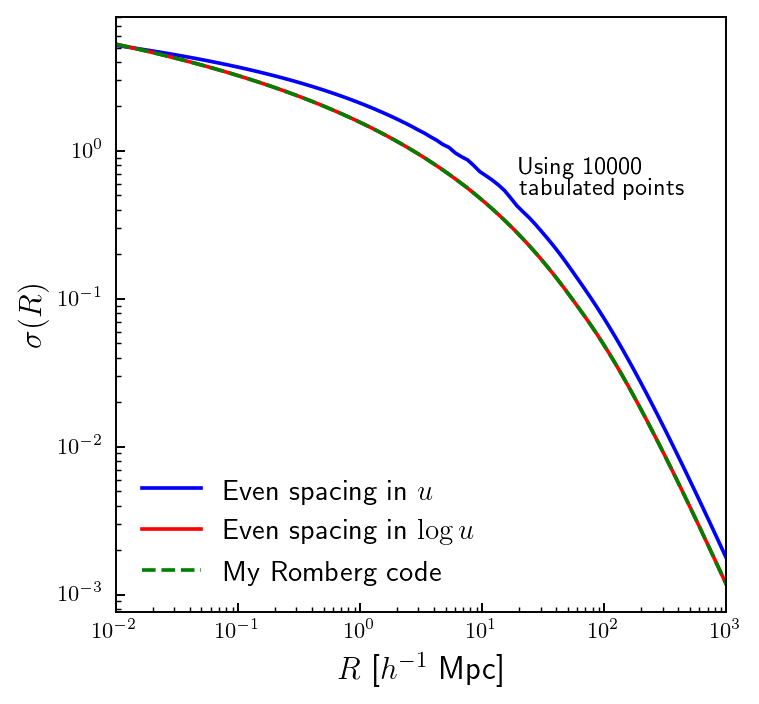

In [66]:
plt.figure(figsize=(4.5,4.5))

plt.plot(R, sigma_interp_evenu, c='b', label=r'Even spacing in $u$')
plt.plot(R, sigma_interp_evenlogu, c='r', label=r'Even spacing in $\log u$')
plt.plot(R, sigma_my_code , c='g', ls='--', label=r'My Romberg code')

plt.xscale('log');plt.yscale('log')

plt.xlim(1.0e-2, 1.0e3)

plt.xlabel('$R$ [$h^{-1}$ Mpc]', fontsize='13');plt.ylabel('$\sigma(R)$', fontsize='13')

plt.text(2.0e1,0.7, 'Using 10000', fontsize=10)
plt.text(2.0e1,0.5, 'tabulated points', fontsize=10)
plt.legend(frameon=False, loc='lower left', fontsize=12)
plt.show()

As we can see, using 10000 tabulated points,  gives a result (for the case of even spacing in $u$) much better (much closer to the Romberg integration). Let's plot the fractional difference again.

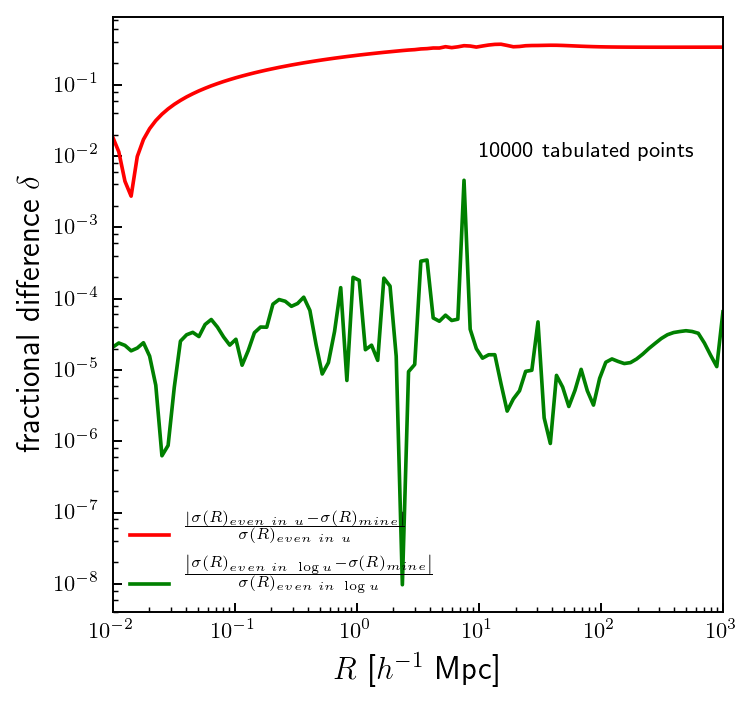

In [67]:
frac_dif_3 = np.abs(sigma_my_code - sigma_interp_evenu)/sigma_interp_evenu

frac_dif_4 = np.abs(sigma_my_code - sigma_interp_evenlogu)/sigma_interp_evenlogu


plt.figure(figsize=(4.5,4.5))

plt.plot(R, frac_dif_3, c='r', label=r'$\frac{\left|\sigma(R)_{even\,\,in\,\,u} - \sigma(R)_{mine}\right|}{\sigma(R)_{even\,\,in\,\,u}}$')
plt.plot(R, frac_dif_4, c='g', label=r'$\frac{\left|\sigma(R)_{even\,\,in\,\,\log u} - \sigma(R)_{mine}\right|}{\sigma(R)_{even\,\,in\,\,\log u}}$')
plt.xscale('log');plt.yscale('log')

plt.xlabel('$R$ [$h^{-1}$ Mpc]', fontsize='13');plt.ylabel('fractional difference $\delta$', fontsize='13')
plt.xlim(1.0e-2, 1.0e3)
#plt.ylim(1.0e-9,1.0e4)

plt.text(10,0.01, r'10000 tabulated points')
plt.legend(frameon=False, loc='lower left', fontsize=8)

plt.show()

Finally let's repeat the calculation using 100000 tabulated points.

In [68]:
for i in range(0,N):
    r_i = R[i]
    prefact = (1.0/(r_i**3.0))*(9.0/(np.pi**2.0))/2.0
    
    #===============================================================================================
    #===============================================================================================
    # First, for each R, calculation of the integral and sigma using 1000 tabulated points
    # of u evenly spaced 
    
    u_even = np.linspace(1.0e-5, 1.0e4, 100000)
    
    integrand_even_u = (cosmo.matterPowerSpectrum(u_even/r_i, 'eh98'))*((np.sin(u_even) - u_even*np.cos(u_even))**2.0)/(u_even**4.0)
    
    # Now interpolate to find the integrand for every u
    
    spl_integ_even_u = UnivariateSpline(u_even, integrand_even_u, s=0.0)
    
    #calculate the integral using the spline method 
    
    sigma_sq = prefact*(spl_integ_even_u.integral(1.0e-5, 1.0e4))
    
    sigma_interp_evenu[i] = np.sqrt(sigma_sq)
    
    #==============================================================================================
    #==============================================================================================
    # Now, for R, calculation of the integral and sigma using 1000 tabulated points
    # of even space in logu 
    
    u_even_log = np.linspace(-5.0,4.0,100000)
    
    x_var = 10.0**u_even_log 
    
    integrand_even_log = (cosmo.matterPowerSpectrum(x_var/r_i, 'eh98'))*((np.sin(x_var) - x_var*np.cos(x_var))**2.0)/(x_var**3.0)
    
    # Now interpolate
    
    spl_integ_even_log = UnivariateSpline(u_even_log, integrand_even_log, s=0.0)
    
    #calculate the integral using the spline method 
    
    sigma_sq_2 = prefact*(spl_integ_even_log.integral(-5.0,4.0))
    
    sigma_interp_evenlogu[i] = np.sqrt(sigma_sq_2)

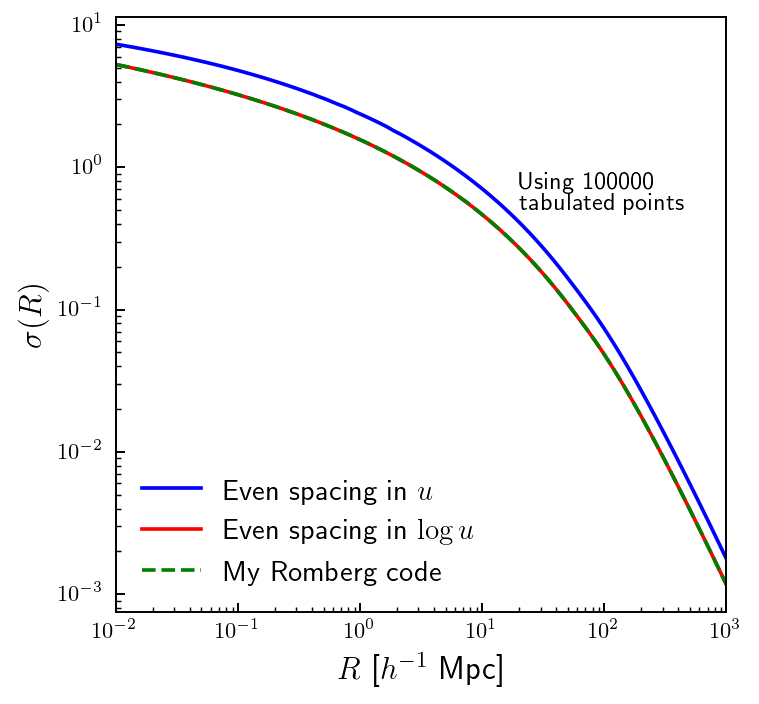

In [69]:
plt.figure(figsize=(4.5,4.5))

plt.plot(R, sigma_interp_evenu, c='b', label=r'Even spacing in $u$')
plt.plot(R, sigma_interp_evenlogu, c='r', label=r'Even spacing in $\log u$')
plt.plot(R, sigma_my_code , c='g', ls='--', label=r'My Romberg code')

plt.xscale('log');plt.yscale('log')

plt.xlim(1.0e-2, 1.0e3)

plt.xlabel('$R$ [$h^{-1}$ Mpc]', fontsize='13');plt.ylabel('$\sigma(R)$', fontsize='13')

plt.text(2.0e1,0.7, 'Using 100000', fontsize=10)
plt.text(2.0e1,0.5, 'tabulated points', fontsize=10)
plt.legend(frameon=False, loc='lower left', fontsize=12)
plt.show()

### 2c (5 points) Using spline for root finding.

Construct the inverse spline approximation of $R(\sigma)$ for a specified number of tabulated value pairs $\{R_i,\sigma(R_i)\}$ you computed in 2b. Compute and output the radius of typical density perturbations collapse in the universe today by computing $R(\sigma=1.69)$ using the spline you constructed.

Hint: Note that when we spline some $f(x)$, spline routine expects $x$ to be in ascending order, i.e. $x$ with larger indices are larger. When you spline $R(\sigma)$ make sure that $\{R_i\}$ and $\{\sigma_i\}$ are sorted such that the latter is in ascending order. Otherwise, routine will either crash or the spline will be garbage. If you need to reverse order of entries in array sigma or R, in python this can be done very simply: sigma[::-1] or R[::-1].

##### Required tests and follow up questions: 
How does the radius you computed compare to the size of the largest collapsed objects we know, clusters of galaxies?

### Solution

We will use the result from the evenly spaced in $\log u$.

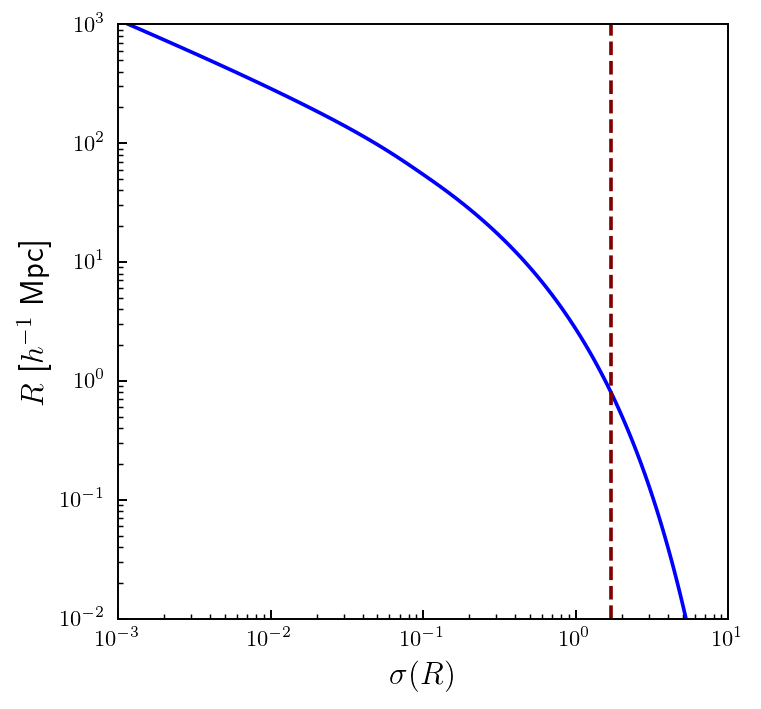

In [70]:
# First: reverse the arrays 

sigma_arr = sigma_interp_evenlogu[::-1]
R_arr = R[::-1]

# Let's plot to see 


plt.figure(figsize=(4.5,4.5))

plt.plot(sigma_arr, R_arr, c='b')


plt.xscale('log');plt.yscale('log')
plt.xlim(1.0e-3,10)
plt.ylim(1.0e-2, 1.0e3) 

plt.xlabel('$\sigma(R)$', fontsize='13')
plt.ylabel('$R$ [$h^{-1}$ Mpc]', fontsize='13')

plt.axvline(1.69, c='maroon', ls='--')

plt.legend(frameon=False, loc='lower left', fontsize=12)
plt.show()

In [82]:
# Now we interpolate the points to obtain a continous function.

#R as a function of sigma

R_sigma = UnivariateSpline(sigma_arr, R_arr, s=0.0)

#Now, let's print R for sigma = 1.69

sigma_0 = 1.69

print('Radius $R(\sigma = 1.69)$:')
print(R_sigma(1.69))
print('$h^{-1} Mpc$')

Radius $R(\sigma = 1.69)$:
0.813040519673
$h^{-1} Mpc$


### 2d (15 points).

Parallelize your Romberg integration routine with MPI by splitting integration interval into independent segments and applying Romberg integration on each one independently. Test your implementation and check how its performance scales with a different number of processors.

Hints: You can use example of parallelization of Monte Carlo integration with mpi4py given in the lecture by Igor Yakushin in Lab 7 or example of parallel computation of integral with trapezoidal quadrature here. You can also check out this tutorial on mpi4py.

As you split the integration interval into a number of segments to distribute to $N_p$ cores, note that fractional error tolerance for each segment must be increased to ensure the required tolerance level for the integral.
To test your code, you will need to run it on a system where mpi4py is installed (it comes standard with Anaconda python distro) and which has at least 2 cores to see the effect of parallelization. For scaling test requested below you should run it on the midway2 cluster in sinteractive mode or in batch mode. For example, you can ask for sinteractive shell on midway as follows: 

    sinteractive --account=astr33000 --partition=broadwl --nodes=1 --exclusive --time=1:30:00
    
This asks for shell on one node to be used exclusively under our class account on broadwl partition. Exclusive use of the node ensures that your timing tests are not affected by other users running jobs on the same cores (in which case CPU time is shared between jobs). See Igor Yakushin's notes for more info on midway cluster and how to run jobs on it, as well as on how to use MPI to parallelize code.

Don't forget to exit the shell once you are done by typing exit! Otherwise, you will be occupying the node (and we will be charged for it) for a couple more hours.

If you don't get your Romberg integration routine to work properly, use the scipy Romberg routine to do the job.
Required tests and follow up questions: Test your implementation using test integral from 1. When tested, use it to compute $\sigma(R)$ to fractional accuracy of $10^{-8}$ for a range of $R$, as before.

Time computation of the integral for different number of cores on a node you are using exclusively. Plot the speed-up, defined as $s_N=t_1/t_{N}$, where $t_1$ and $t_N$ is the wall-clock time it takes to compute the integral on 1 and $N$ cores, as a function of number of cores $N$. Do you see speed up for larger number of cores? How close $s_N$ is to the ideal scaling of $s_N\propto N$?

### Solution

##### Coming soon